In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install pytorch-metric-learning

In [2]:
import pandas as pd
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

folder = 'IMAGES_OF_Vincent van Gogh'
all_pictures = os.listdir(folder)

file_path = "IMAGES_OF_Vincent van Gogh.csv"
df = pd.read_csv(file_path)

# Reemplazar el prefijo "c." con nada en la columna 'date'
"""
df['date'] = df['date'].str.replace(r'c\.', '', regex=True)

df['date'] = df['date'].str.replace(r'\.0$', '', regex=True)

df['date'] = df['date'].str.extract(r'(\d+)', expand=False)

df['date'] = df['date'].astype(int)
"""
print(df.head())

NUM_CLASSES = len(df['date'].unique().tolist())

print("Number of classes:", NUM_CLASSES)

             artist  date new_filename
0  Vincent van Gogh  1887    75309.jpg
1  Vincent van Gogh  1886    21520.jpg
2  Vincent van Gogh  1890    61388.jpg
3  Vincent van Gogh  1890    87903.jpg
4  Vincent van Gogh  1889    26488.jpg
Number of classes: 13


In [3]:
import os
import shutil
import random
import pandas as pd


In [4]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [5]:
# GROUP THE FILES BY EACH date
import random
def group_files_per_date():
  data_per_date = {}

  # Iterate over each row of the DataFrame
  for index, row in df.iterrows():
      date = row['date']
      new_filename = row['new_filename']

      # Check if the date is already in the dictionary
      if date in data_per_date:
          # Add the new_filename to the existing list of the date
          data_per_date[date].append(new_filename)
      else:
          # Create a new list for the date and add the new_filename
          data_per_date[date] = [new_filename]

  return data_per_date

# SPLIT THE FILES INTO TRAIN AND TEST SETS (CREATE NEW DATASETS)
def split_test_train(data_per_date, train_percentage = 0.8):

  TRAIN_names = []
  TEST_names = []

  # Iterate over each date and their 'new_filename'
  for date, filenames in data_per_date.items():
      # Calculate the number of files for training and testing
      total_files = len(filenames)
      num_train = int(train_percentage * total_files)

      # Shuffle the filenames to avoid selection biases
      random.shuffle(filenames)

      # Divide the filenames into train and test
      train_filenames = filenames[:num_train]
      test_filenames = filenames[num_train:]

      # Store the divided filenames into train and test
      TRAIN_names.extend(train_filenames)
      TEST_names.extend(test_filenames)
  return TRAIN_names, TEST_names



# CREATE TEST and TRAIN folders
def create_train_test_folders(folder, TRAIN_names, TEST_names):
    # Output folder for TRAIN and TEST
    train_folder = os.path.join(folder, 'TRAIN')
    test_folder = os.path.join(folder, 'TEST')

    # Create TRAIN and TEST folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move images from TRAIN to TRAIN folder
    for filename in TRAIN_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(train_folder, filename)
        shutil.move(src, dst)

    # Move images from TEST to TEST folder
    for filename in TEST_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(test_folder, filename)
        shutil.move(src, dst)

    # Create df_train with rows whose 'new_filename' is in TRAIN_names and keep only 'date' and 'new_filename' columns
    train_dataframe = df[df['new_filename'].isin(TRAIN_names)][['date', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'train_dataframe.csv')
    # Save the DataFrame as CSV
    train_dataframe.to_csv(file_path, index=False)

    # Create df_test with rows whose 'new_filename' is in TEST_names and keep only 'date' and 'new_filename' columns
    test_dataframe = df[df['new_filename'].isin(TEST_names)][['date', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'test_dataframe.csv')
    # Save the DataFrame as CSV
    test_dataframe.to_csv(file_path, index=False)

    return train_dataframe, test_dataframe

if not (os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST')) and os.path.exists(os.path.join(folder, 'train_dataframe.csv'))):
  # Group files per date
  data_per_date = group_files_per_date()
  # Print the number of files for each date
  print("- date and numer of images:")
  for key in data_per_date.keys():
    print(key, len(data_per_date[key]))

  # Split data
  TRAIN_names, TEST_names = split_test_train(data_per_date)

  # Use the function to create TRAIN and TEST folders
  train_dataframe, test_dataframe = create_train_test_folders(folder, TRAIN_names, TEST_names)
  print("\nImages successfully moved to TRAIN and TEST folders.")
else:
  print("TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...")

  # Read train and test DataFrames from CSV files
  train_folder = os.path.join(folder, 'TRAIN')
  test_folder = os.path.join(folder, 'TEST')

  train_images = set(os.listdir(train_folder))
  test_images = set(os.listdir(test_folder))

  train_dataframe = df[df['new_filename'].isin(train_images)].copy()
  test_dataframe = df[df['new_filename'].isin(test_images)].copy()

  train_dataframe = train_dataframe[['new_filename', 'date']]
  test_dataframe = test_dataframe[['new_filename', 'date']]
'''
  train_dataframe['date'] = train_dataframe['date'].str.replace(r'c\.', '', regex=True)

  train_dataframe['date'] = train_dataframe['date'].str.replace(r'\.0$', '', regex=True)

  train_dataframe['date'] = train_dataframe['date'].str.extract(r'(\d+)', expand=False)

  train_dataframe['date'] = train_dataframe['date'].astype(int)

  test_dataframe['date'] = test_dataframe['date'].str.replace(r'c\.', '', regex=True)

  test_dataframe['date'] = test_dataframe['date'].str.replace(r'\.0$', '', regex=True)

  test_dataframe['date'] = test_dataframe['date'].str.extract(r'(\d+)', expand=False)

  test_dataframe['date'] = test_dataframe['date'].astype(int)
'''

print("Train DataFrame:", train_dataframe.shape)
print("Test DataFrame:", test_dataframe.shape)


TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...
Train DataFrame: (383, 2)
Test DataFrame: (103, 2)


In [6]:
train_dataframe.groupby('date').size().reset_index(name='count')

,date,count
0,1879,2
1,1881,6
2,1882,27
3,1883,21
4,1884,16
5,1885,59
6,1886,48
7,1887,64
8,1888,61
9,1889,41


In [7]:
test_dataframe.groupby('date').size().reset_index(name='count')

,date,count
0,1873,1
1,1878,1
2,1879,1
3,1881,2
4,1882,7
5,1883,6
6,1884,4
7,1885,15
8,1886,13
9,1887,16


In [8]:
unique_dates_train = train_dataframe['date'].unique()
test_dataframe = test_dataframe[test_dataframe['date'].isin(unique_dates_train)]
test_dataframe.groupby('date').size().reset_index(name='count')

,date,count
0,1879,1
1,1881,2
2,1882,7
3,1883,6
4,1884,4
5,1885,15
6,1886,13
7,1887,16
8,1888,16
9,1889,11


In [9]:
unique_dates = df['date'].unique()
unique_dates
idx2date = {}
date2idx = {}

for i,date in enumerate(unique_dates):
  idx2date[i] = date
  date2idx[date] = i

print(idx2date)
print(date2idx)


{0: 1887, 1: 1886, 2: 1890, 3: 1889, 4: 1885, 5: 1888, 6: 1884, 7: 1883, 8: 1882, 9: 1879, 10: 1881, 11: 1873, 12: 1878}
{1887: 0, 1886: 1, 1890: 2, 1889: 3, 1885: 4, 1888: 5, 1884: 6, 1883: 7, 1882: 8, 1879: 9, 1881: 10, 1873: 11, 1878: 12}


In [10]:
for index, row in train_dataframe.iterrows():
    train_dataframe.at[index, 'date'] = date2idx[row['date']]

for index, row in test_dataframe.iterrows():
    test_dataframe.at[index, 'date'] = date2idx[row['date']]

print("Train DataFrame:")
print(train_dataframe.head())

print("\nTest DataFrame:")
print(test_dataframe.head())


Train DataFrame:
  new_filename  date
1    21520.jpg     1
2    61388.jpg     2
3    87903.jpg     2
4    26488.jpg     3
5    60631.jpg     4

Test DataFrame:
   new_filename  date
0     75309.jpg     0
15    25444.jpg     5
30    73970.jpg     5
49    40012.jpg     2
52    18464.jpg     3


In [11]:
idx2date

{0: 1887,
 1: 1886,
 2: 1890,
 3: 1889,
 4: 1885,
 5: 1888,
 6: 1884,
 7: 1883,
 8: 1882,
 9: 1879,
 10: 1881,
 11: 1873,
 12: 1878}

In [12]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator



# NETWORK

In [13]:
from pytorch_metric_learning import losses
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [14]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)  # Cambiado de 1 a 3 canales
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(110 * 110 * 64, 128)  # Ajustado a la salida de las convoluciones y pooling
        self.fc2 = nn.Linear(128, num_classes)  # Nueva capa totalmente conectada para las clases

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)  # Salida de la última capa para la clasificación
        return x

In [15]:
# Paths of the training and testing folders
train_folder = 'IMAGES_OF_Vincent van Gogh/TRAIN'
test_folder = 'IMAGES_OF_Vincent van Gogh/TEST'

In [16]:
device = torch.device("cuda")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4902860351171657, 0.4327027123349515, 0.3679902021355657], std=[0.22134062718873712, 0.20430693703606892, 0.18851782142531143])  # Normalization for color images
])

## Lo del pip install fiass es primer instalarlo i despres desinstalarlo, despres tornarlo a instalar i donara opcio de reiniciar entorno ejecucion (dir k si), anar fent aixo fins que doni opcio reiniciar entorno ejecucion. Llavors sha de tornar a excutar tot excepte aquestes dues celes.

## Anar instalant i desinstalant fins que al instalar dongui l'opcio de reiniciar kernel


In [32]:
!pip uninstall faiss-gpu
!pip uninstall faiss-cpu

Found existing installation: faiss-gpu 1.7.2
Uninstalling faiss-gpu-1.7.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/faiss/*
    /usr/local/lib/python3.10/dist-packages/faiss_gpu-1.7.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/faiss_gpu.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/faiss_gpu.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/faiss_gpu.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/faiss_gpu.libs/libz-745e0a09.so.1.2.7
  Would not remove (might be manually added):
    /usr/local/lib/python3.10/dist-packages/faiss/_swigfaiss_avx2.cpython-310-x86_64-linux-gnu.so
    /usr/local/lib/python3.10/dist-packages/faiss/_swigfaiss_avx512.cpython-310-x86_64-linux-gnu.so
    /usr/local/lib/python3.10/dist-packages/faiss/array_conversions.py
    /usr/local/lib/python3.10/dist-packages/faiss/class_wrappers.py
    /usr/local/lib/python3.10/dist-packages/faiss/contrib

In [19]:
!pip install faiss-gpu
!pip install faiss-cpu

     |████████████████████████████████| 85.5 MB 52 kB/s  eta 0:00:013
     |████████████████████████████████| 27.0 MB 19.4 MB/s eta 0:00:01


# Versió de BATCH customitzat (imatges d'un mateix artista per batch)

In [17]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Sampler
from collections import defaultdict
import random
import torch


class CustomDataset(Dataset):
    def __init__(self, dataframe, folder, df, transform=None):
        self.dataframe = dataframe
        self.folder = folder
        self.transform = transform
        self.df = df.set_index('new_filename')
        self.artists = self.dataframe['new_filename'].apply(lambda x: self.df.at[x, 'artist']).values # Artistes de cada imatge

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        date = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, date

class GroupedBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.groups = self._group_by_artist()
        self.batches = self._create_batches()

    def _group_by_artist(self):
        groups = defaultdict(list)
        for idx in range(len(self.dataset)):
            artist = self.dataset.artists[idx]
            groups[artist].append(idx)
        return groups

    def _create_batches(self):
        batches = []
        for artist, indices in self.groups.items():
            num_samples = len(indices)
            if num_samples <= self.batch_size:
                batch = indices
                batches.append(batch)
            else:
                num_batches = num_samples // self.batch_size
                for i in range(num_batches):
                    start_index = i * self.batch_size
                    end_index = (i + 1) * self.batch_size
                    batch = indices[start_index:end_index]
                    batches.append(batch)

                # Añadir el lote final si hay elementos restantes
                remaining_samples = num_samples % self.batch_size
                if remaining_samples > 0:
                    start_index = num_batches * self.batch_size
                    batch = indices[start_index:start_index + remaining_samples]
                    batches.append(batch)
        return batches

    def __iter__(self):
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

def custom_collate_fn(batch):
    images, dates = zip(*batch)
    images = torch.stack([img for img in images])
    dates = torch.tensor(dates)
    return images, dates


batch_size = 32

# Definir las rutas de las carpetas de entrenamiento y prueba
train_folder = 'IMAGES_OF_Vincent van Gogh/TRAIN'
test_folder = 'IMAGES_OF_Vincent van Gogh/TEST'
# Crear datasets
train_dataset = CustomDataset(train_dataframe, train_folder, df, transform=transform)
test_dataset = CustomDataset(test_dataframe, test_folder, df, transform=transform)

# Crear samplers personalizados
train_sampler = GroupedBatchSampler(train_dataset, batch_size)
test_sampler = GroupedBatchSampler(test_dataset, batch_size)

# Crear DataLoaders con los samplers personalizados
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_sampler=test_sampler, collate_fn=custom_collate_fn)

# Función de entrenamiento
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = 0.0  # Inicializa la pérdida acumulada en la época
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # Acumula la pérdida del lote en la pérdida de la época

    epoch_loss /= len(train_loader)  # Calcula el promedio de la pérdida de la época
    print("Epoch {}: Average Loss = {}".format(epoch, epoch_loss))  # Imprime la pérdida promedio de la época

    return epoch_loss  # Devuelve la pérdida promedio de la época

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    embeddings, labels = tester.get_all_embeddings(dataset, model)
    return embeddings, labels

def precision_at_k(test_embeddings, test_labels, train_embeddings, train_labels, k):
    # Compute pairwise distances between test and train embeddings
    distances = torch.cdist(test_embeddings, train_embeddings)
    # Get the indices of the k nearest neighbors
    knn_indices = distances.topk(k, largest=False).indices
    # Retrieve the labels of the k nearest neighbors
    knn_labels = train_labels[knn_indices]
    # Check if the test label is in the k nearest neighbors
    matches = (knn_labels == test_labels.unsqueeze(1)).sum(dim=1).float()
    # Calculate precision
    precision = (matches > 0).sum().item() / len(test_labels)
    return precision

def test(train_set, test_set, model, accuracy_calculator, loss_func):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    
    # Compute accuracies using accuracy_calculator
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    print("Test set accuracy (r_precision) = {}".format(accuracies["r_precision"]))

    # Compute custom precision_at_3
    precision_at_3 = precision_at_k(test_embeddings, test_labels, train_embeddings, train_labels, k=3)
    print("Test set accuracy (Precision@3) = {}".format(precision_at_3))
    
    return accuracies["precision_at_1"], precision_at_3, accuracies["r_precision"]

In [31]:
'''
for i in train_sampler.batches:
  print(train_dataframe.iloc[i])
  print("\n")
'''

'\nfor i in train_sampler.batches:\n  print(train_dataframe.iloc[i])\n  print("\n")\n'

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pytorch_metric_learning import miners, losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.distances import CosineSimilarity, LpDistance
from pytorch_metric_learning.reducers import ThresholdReducer
import matplotlib.pyplot as plt
import faiss


accuracy_calculator = AccuracyCalculator(include=("precision_at_1", "r_precision"), k='max_bin_count') # ficar precision at R
### pytorch-metric-learning stuff ###

In [19]:
def plot_metrics(losses, precision_at_1, precision_at_3, r_precision):
    epochs = range(1, len(losses) + 1)
    
    plt.figure(figsize=(18, 6))

    # Plot losses
    plt.subplot(1, 3, 1)
    plt.plot(epochs, losses, 'r', label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()

    # Plot precision_at_1
    plt.subplot(1, 3, 2)
    plt.plot(epochs, precision_at_1, 'b', label='Precision@1')
    plt.plot(epochs, precision_at_3, 'g', label='Precision@3')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Precision@1 and Precision@3 over epochs')
    plt.legend()

    # Plot r_precision
    plt.subplot(1, 3, 3)
    plt.plot(epochs, r_precision, 'm', label='R Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('R Precision over epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1: Average Loss = 0.2370631955564022


100%|██████████| 4/4 [00:00<00:00, 10.05it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2871287128712871
Test set accuracy (r_precision) = 0.16506448046614083
Test set accuracy (Precision@3) = 0.49504950495049505
Epoch 2: Average Loss = 0.21830178797245026


100%|██████████| 4/4 [00:00<00:00, 15.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.24752475247524752
Test set accuracy (r_precision) = 0.16702157522157127
Test set accuracy (Precision@3) = 0.48514851485148514
Epoch 3: Average Loss = 0.2129812054336071


100%|██████████| 4/4 [00:00<00:00, 15.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3069306930693069
Test set accuracy (r_precision) = 0.16904914464818563
Test set accuracy (Precision@3) = 0.49504950495049505
Epoch 4: Average Loss = 0.21720047543446222


100%|██████████| 4/4 [00:00<00:00, 14.67it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2871287128712871
Test set accuracy (r_precision) = 0.17293575248679152
Test set accuracy (Precision@3) = 0.504950495049505
Epoch 5: Average Loss = 0.21013182401657104


100%|██████████| 4/4 [00:00<00:00, 15.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2376237623762376
Test set accuracy (r_precision) = 0.1747098820716212
Test set accuracy (Precision@3) = 0.49504950495049505
Epoch 6: Average Loss = 0.2170532370607058


100%|██████████| 4/4 [00:00<00:00, 15.29it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.26732673267326734
Test set accuracy (r_precision) = 0.17652140799742655
Test set accuracy (Precision@3) = 0.43564356435643564
Epoch 7: Average Loss = 0.21588941663503647


100%|██████████| 4/4 [00:00<00:00, 15.46it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.27722772277227725
Test set accuracy (r_precision) = 0.18449393909708753
Test set accuracy (Precision@3) = 0.45544554455445546
Epoch 8: Average Loss = 0.21246536200245222


100%|██████████| 4/4 [00:00<00:00, 15.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2871287128712871
Test set accuracy (r_precision) = 0.18372274325460355
Test set accuracy (Precision@3) = 0.44554455445544555
Epoch 9: Average Loss = 0.21958190451065698


100%|██████████| 4/4 [00:00<00:00, 15.34it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.27722772277227725
Test set accuracy (r_precision) = 0.18586761529117965
Test set accuracy (Precision@3) = 0.48514851485148514
Epoch 10: Average Loss = 0.21645473316311836


100%|██████████| 4/4 [00:00<00:00, 15.26it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2871287128712871
Test set accuracy (r_precision) = 0.18934374931310263
Test set accuracy (Precision@3) = 0.5544554455445545
Epoch    10: reducing learning rate of group 0 to 1.0000e-06.
Epoch 11: Average Loss = 0.21734571953614554


100%|██████████| 4/4 [00:00<00:00, 15.39it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.27722772277227725
Test set accuracy (r_precision) = 0.1895228344511613
Test set accuracy (Precision@3) = 0.5544554455445545
Epoch 12: Average Loss = 0.21061806504925093


100%|██████████| 4/4 [00:00<00:00, 14.88it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.27722772277227725
Test set accuracy (r_precision) = 0.19011040068732357
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 13: Average Loss = 0.20549897228678068


100%|██████████| 4/4 [00:00<00:00, 15.33it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2871287128712871
Test set accuracy (r_precision) = 0.1892291717054096
Test set accuracy (Precision@3) = 0.5742574257425742
Epoch 14: Average Loss = 0.21736890077590942


100%|██████████| 4/4 [00:00<00:00, 15.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.27722772277227725
Test set accuracy (r_precision) = 0.19143187978337034
Test set accuracy (Precision@3) = 0.5742574257425742
Epoch 15: Average Loss = 0.2121636817852656


100%|██████████| 4/4 [00:00<00:00, 15.38it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2871287128712871
Test set accuracy (r_precision) = 0.19343511468770583
Test set accuracy (Precision@3) = 0.5445544554455446
Epoch 16: Average Loss = 0.21531577284137407


100%|██████████| 4/4 [00:00<00:00, 15.45it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.31683168316831684
Test set accuracy (r_precision) = 0.19626093318531862
Test set accuracy (Precision@3) = 0.5445544554455446
Epoch 17: Average Loss = 0.21471822261810303


100%|██████████| 4/4 [00:00<00:00, 15.07it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.1972890014943062
Test set accuracy (Precision@3) = 0.5445544554455446
Epoch 18: Average Loss = 0.21624950940410295


100%|██████████| 4/4 [00:00<00:00, 14.91it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3564356435643564
Test set accuracy (r_precision) = 0.1991008672838642
Test set accuracy (Precision@3) = 0.5247524752475248
Epoch    18: reducing learning rate of group 0 to 1.0000e-07.
Epoch 19: Average Loss = 0.21528909107049307


100%|██████████| 4/4 [00:00<00:00, 15.51it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3564356435643564
Test set accuracy (r_precision) = 0.19960430745839014
Test set accuracy (Precision@3) = 0.5247524752475248
Epoch 20: Average Loss = 0.20737763618429503


100%|██████████| 4/4 [00:00<00:00, 15.54it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3564356435643564
Test set accuracy (r_precision) = 0.1993999154344883
Test set accuracy (Precision@3) = 0.5346534653465347
Epoch 21: Average Loss = 0.20707306390007338


100%|██████████| 4/4 [00:00<00:00, 15.38it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3564356435643564
Test set accuracy (r_precision) = 0.19927606135694384
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 22: Average Loss = 0.20832855006059012


100%|██████████| 4/4 [00:00<00:00, 15.22it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3564356435643564
Test set accuracy (r_precision) = 0.19896665541634972
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 23: Average Loss = 0.2039544607202212


100%|██████████| 4/4 [00:00<00:00, 15.44it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3564356435643564
Test set accuracy (r_precision) = 0.19944598101284383
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 24: Average Loss = 0.21896622329950333


100%|██████████| 4/4 [00:00<00:00, 15.54it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3564356435643564
Test set accuracy (r_precision) = 0.1993532420333259
Test set accuracy (Precision@3) = 0.5544554455445545
Epoch 25: Average Loss = 0.20515966912110647


100%|██████████| 4/4 [00:00<00:00, 15.20it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.19933550356178492
Test set accuracy (Precision@3) = 0.5445544554455446
Epoch 26: Average Loss = 0.21675814564029375


100%|██████████| 4/4 [00:00<00:00, 15.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20060231597005074
Test set accuracy (Precision@3) = 0.5544554455445545
Epoch 27: Average Loss = 0.2142590507864952


100%|██████████| 4/4 [00:00<00:00, 14.93it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20136630851560325
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 28: Average Loss = 0.21312747399012247


100%|██████████| 4/4 [00:00<00:00, 15.43it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20128667995729696
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch    28: reducing learning rate of group 0 to 1.0000e-08.
Epoch 29: Average Loss = 0.21123144154747328


100%|██████████| 4/4 [00:00<00:00, 15.16it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20144899127039545
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 30: Average Loss = 0.211630180478096


100%|██████████| 4/4 [00:00<00:00, 15.44it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20135075021246737
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 31: Average Loss = 0.20473802462220192


100%|██████████| 4/4 [00:00<00:00, 13.87it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.2015054531827644
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 32: Average Loss = 0.2153366096317768


100%|██████████| 4/4 [00:00<00:00, 15.20it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.2015054531827644
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 33: Average Loss = 0.20471759885549545


100%|██████████| 4/4 [00:00<00:00, 15.40it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.2015054531827644
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 34: Average Loss = 0.21196811646223068


100%|██████████| 4/4 [00:00<00:00, 15.14it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20167326657427306
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 35: Average Loss = 0.2148869422574838


100%|██████████| 4/4 [00:00<00:00, 14.51it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20187953720133575
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 36: Average Loss = 0.21013892193635306


100%|██████████| 4/4 [00:00<00:00, 14.87it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20187953720133575
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 37: Average Loss = 0.21249298254648843


100%|██████████| 4/4 [00:00<00:00, 14.19it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20214008957236232
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 38: Average Loss = 0.2088684824605783


100%|██████████| 4/4 [00:00<00:00, 15.04it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20240064194338891
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 39: Average Loss = 0.21275544166564941


100%|██████████| 4/4 [00:00<00:00, 15.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20224593897309187
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 40: Average Loss = 0.2059198891123136


100%|██████████| 4/4 [00:00<00:00, 14.56it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20224593897309187
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 41: Average Loss = 0.21021058286229768


100%|██████████| 4/4 [00:00<00:00, 15.40it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20240825028619042
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 42: Average Loss = 0.21393724406758943


100%|██████████| 4/4 [00:00<00:00, 15.46it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20240825028619042
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 43: Average Loss = 0.2123043400545915


100%|██████████| 4/4 [00:00<00:00, 14.52it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20240825028619042
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 44: Average Loss = 0.21185768271485964


100%|██████████| 4/4 [00:00<00:00, 15.13it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.20240825028619042
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 45: Average Loss = 0.20813802629709244


100%|██████████| 4/4 [00:00<00:00, 14.54it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.34653465346534656
Test set accuracy (r_precision) = 0.2029315351966487
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 46: Average Loss = 0.210715401917696


100%|██████████| 4/4 [00:00<00:00, 14.75it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.2029315351966487
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 47: Average Loss = 0.20445555821061134


100%|██████████| 4/4 [00:00<00:00, 15.31it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20325405155845436
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 48: Average Loss = 0.2062976062297821


100%|██████████| 4/4 [00:00<00:00, 15.35it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20325405155845436
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 49: Average Loss = 0.21432755018273988


100%|██████████| 4/4 [00:00<00:00, 15.07it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20325405155845436
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 50: Average Loss = 0.20699101810654005


100%|██████████| 4/4 [00:00<00:00, 15.09it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20325405155845436
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 51: Average Loss = 0.21594263116518655


100%|██████████| 4/4 [00:00<00:00, 15.02it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20325405155845436
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 52: Average Loss = 0.20388888319333395


100%|██████████| 4/4 [00:00<00:00, 15.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20325405155845436
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 53: Average Loss = 0.20737089837590852


100%|██████████| 4/4 [00:00<00:00, 15.19it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20325405155845436
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 54: Average Loss = 0.2107805460691452


100%|██████████| 4/4 [00:00<00:00, 15.30it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20325405155845436
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 55: Average Loss = 0.20275219654043516


100%|██████████| 4/4 [00:00<00:00, 15.02it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20325405155845436
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 56: Average Loss = 0.20740380759040514


100%|██████████| 4/4 [00:00<00:00, 15.02it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20325405155845436
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 57: Average Loss = 0.2053655224541823


100%|██████████| 4/4 [00:00<00:00, 15.25it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20325405155845436
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 58: Average Loss = 0.21074855203429857


100%|██████████| 4/4 [00:00<00:00, 14.38it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20325405155845436
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 59: Average Loss = 0.20968671639760336


100%|██████████| 4/4 [00:00<00:00, 14.71it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.20316131257893644
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 60: Average Loss = 0.21143889799714088


100%|██████████| 4/4 [00:00<00:00, 14.63it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.20316131257893644
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 61: Average Loss = 0.21366534506281218


100%|██████████| 4/4 [00:00<00:00, 14.89it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.20331601554923345
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 62: Average Loss = 0.22089306140939394


100%|██████████| 4/4 [00:00<00:00, 14.90it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.20331601554923345
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 63: Average Loss = 0.21230371793111166


100%|██████████| 4/4 [00:00<00:00, 15.28it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.20331601554923345
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 64: Average Loss = 0.20359900842110315


100%|██████████| 4/4 [00:00<00:00, 15.12it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.20331601554923345
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 65: Average Loss = 0.20791831240057945


100%|██████████| 4/4 [00:00<00:00, 15.33it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.2036827188862338
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 66: Average Loss = 0.20657687882582346


100%|██████████| 4/4 [00:00<00:00, 15.44it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.20385053227774247
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 67: Average Loss = 0.2085389755666256


100%|██████████| 4/4 [00:00<00:00, 14.74it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.20385053227774247
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 68: Average Loss = 0.21132622038324675


100%|██████████| 4/4 [00:00<00:00, 15.03it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.20401834566925112
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 69: Average Loss = 0.2084085134168466


100%|██████████| 4/4 [00:00<00:00, 15.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.20401834566925112
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 70: Average Loss = 0.20861118535200754


100%|██████████| 4/4 [00:00<00:00, 15.28it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.20401834566925112
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 71: Average Loss = 0.21159790828824043


100%|██████████| 4/4 [00:00<00:00, 15.12it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.32673267326732675
Test set accuracy (r_precision) = 0.20401834566925112
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 72: Average Loss = 0.2152723049124082


100%|██████████| 4/4 [00:00<00:00, 14.90it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20370133138585553
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 73: Average Loss = 0.2151088503499826


100%|██████████| 4/4 [00:00<00:00, 15.17it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20370133138585553
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 74: Average Loss = 0.21654114499688148


100%|██████████| 4/4 [00:00<00:00, 15.09it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20370133138585553
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 75: Average Loss = 0.20258694887161255


100%|██████████| 4/4 [00:00<00:00, 15.19it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20370133138585553
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 76: Average Loss = 0.21423485750953355


100%|██████████| 4/4 [00:00<00:00, 14.90it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20370133138585553
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 77: Average Loss = 0.21445497497916222


100%|██████████| 4/4 [00:00<00:00, 15.05it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20410513026234456
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 78: Average Loss = 0.20718611404299736


100%|██████████| 4/4 [00:00<00:00, 15.16it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20414908957630876
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 79: Average Loss = 0.21918252234657606


100%|██████████| 4/4 [00:00<00:00, 15.25it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20447371220250576
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 80: Average Loss = 0.21501388400793076


100%|██████████| 4/4 [00:00<00:00, 14.85it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20431140088940725
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 81: Average Loss = 0.21034140015641847


100%|██████████| 4/4 [00:00<00:00, 15.27it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20493021277059537
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 82: Average Loss = 0.2080476942161719


100%|██████████| 4/4 [00:00<00:00, 14.99it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20476239937908672
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 83: Average Loss = 0.21088068932294846


100%|██████████| 4/4 [00:00<00:00, 15.28it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20476239937908672
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 84: Average Loss = 0.2174274797240893


100%|██████████| 4/4 [00:00<00:00, 15.23it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20493021277059537
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 85: Average Loss = 0.21544475480914116


100%|██████████| 4/4 [00:00<00:00, 15.12it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20493021277059537
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 86: Average Loss = 0.21689177180329958


100%|██████████| 4/4 [00:00<00:00, 14.86it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20431140088940725
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 87: Average Loss = 0.20521656051278114


100%|██████████| 4/4 [00:00<00:00, 15.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20314360946736573
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 88: Average Loss = 0.21461800982554755


100%|██████████| 4/4 [00:00<00:00, 14.53it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20314360946736573
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 89: Average Loss = 0.20880181839068732


100%|██████████| 4/4 [00:00<00:00, 15.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20340416183839233
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 90: Average Loss = 0.21235348780949911


100%|██████████| 4/4 [00:00<00:00, 14.96it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20314360946736573
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 91: Average Loss = 0.20725508034229279


100%|██████████| 4/4 [00:00<00:00, 14.91it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20314360946736573
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 92: Average Loss = 0.2056352160871029


100%|██████████| 4/4 [00:00<00:00, 14.95it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20340416183839233
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 93: Average Loss = 0.21035382772485414


100%|██████████| 4/4 [00:00<00:00, 15.23it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20340416183839233
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 94: Average Loss = 0.21708425506949425


100%|██████████| 4/4 [00:00<00:00, 15.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20340416183839233
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 95: Average Loss = 0.21269038816293082


100%|██████████| 4/4 [00:00<00:00, 15.21it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.2036341499940023
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 96: Average Loss = 0.20937137926618257


100%|██████████| 4/4 [00:00<00:00, 15.06it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.2036341499940023
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 97: Average Loss = 0.20921631281574568


100%|██████████| 4/4 [00:00<00:00, 14.99it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.2033926624306118
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 98: Average Loss = 0.20780881866812706


100%|██████████| 4/4 [00:00<00:00, 15.27it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20356047582212045
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 99: Average Loss = 0.21440453206499419


100%|██████████| 4/4 [00:00<00:00, 15.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20356047582212045
Test set accuracy (Precision@3) = 0.5643564356435643
Epoch 100: Average Loss = 0.20723124345143637


100%|██████████| 4/4 [00:00<00:00, 14.74it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.33663366336633666
Test set accuracy (r_precision) = 0.20356047582212045
Test set accuracy (Precision@3) = 0.5643564356435643
[0.2370631955564022, 0.21830178797245026, 0.2129812054336071, 0.21720047543446222, 0.21013182401657104, 0.2170532370607058, 0.21588941663503647, 0.21246536200245222, 0.21958190451065698, 0.21645473316311836, 0.21734571953614554, 0.21061806504925093, 0.20549897228678068, 0.21736890077590942, 0.2121636817852656, 0.21531577284137407, 0.21471822261810303, 0.21624950940410295, 0.21528909107049307, 0.20737763618429503, 0.20707306390007338, 0.20832855006059012, 0.2039544607202212, 0.21896622329950333, 0.20515966912110647, 0.21675814564029375, 0.2142590507864952, 0.21312747399012247, 0.21123144154747328, 0.211630180478096, 0.20473802462220192, 0.2153366096317768, 0.20471759885549545, 0.21196811646223068, 0.2148869422574838, 0.21013892193635306, 0.21249298254648843, 0.2088684824605783, 0.21275544166564941, 0.205919889

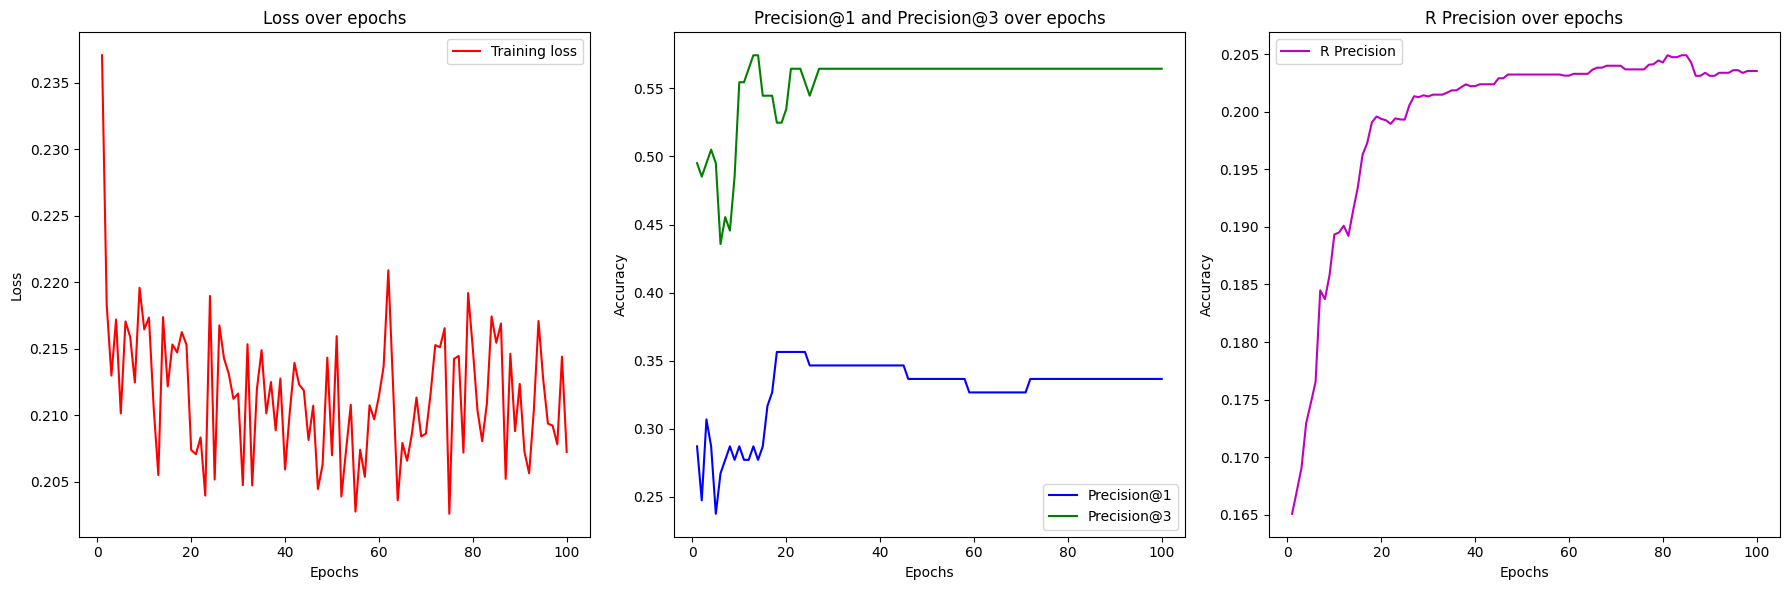

In [20]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = Net(NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
# Pytorch-metric-learning configurations
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

# Pytorch-metric-learning configurations
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)

loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="all")

losses_over_epochs = []
precision_at_1_over_epochs = []
precision_at_3_over_epochs = []
r_precision_over_epochs = []
num_epochs = 100

for epoch in range(1, num_epochs + 1):
    epoch_loss = train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    losses_over_epochs.append(epoch_loss)
    precision_at_1, precision_at_3, r_precision = test(train_dataset, test_dataset, model, accuracy_calculator, loss_func)
    precision_at_1_over_epochs.append(precision_at_1)
    precision_at_3_over_epochs.append(precision_at_3)
    r_precision_over_epochs.append(r_precision)
    scheduler.step(epoch_loss)

print(losses_over_epochs)
print(precision_at_1_over_epochs)
print(precision_at_3_over_epochs)
print(r_precision_over_epochs)
plot_metrics(losses_over_epochs, precision_at_1_over_epochs, precision_at_3_over_epochs, r_precision_over_epochs)

In [78]:
import torch
torch.cuda.empty_cache()

In [35]:
weights = model.resnet.fc.weight

# Suponiendo que las clases se derivan de las filas de los pesos
unique_classes = set(weights.argmax(dim=1).tolist())

# Imprimir las clases únicas
print("Clases únicas en el modelo:", len(unique_classes))
for class_index in unique_classes:
    print(class_index)

Clases únicas en el modelo: 13
1250
333
752
592
1971
724
470
1174
1558
730
379
636
1726


# Evaluate for one artist

In [ ]:
import os
import glob

train_folder = os.path.join(folder, "TEST")
all_files = glob.glob(os.path.join(train_folder, "*"))

ll_imatges = []

for i in all_files:
  ll_imatges.append(i.split("/")[-1])

df_filtered = df[df['new_filename'].isin(ll_imatges)]

ll_artistes = list(set(df_filtered['artist'].tolist()))

print("Artistes:",ll_artistes)

Artistes: ['Vincent van Gogh']


In [ ]:
artist_counts = df_filtered.groupby('artist').size().reset_index(name='count')
artist_counts_sorted = artist_counts.sort_values(by='count', ascending=False)
artist_counts_sorted

,artist,count
0,Vincent van Gogh,103


In [ ]:
df_artist = df_filtered[df_filtered['artist'] == 'Vincent van Gogh']
df_artist_filtered = df_artist[['new_filename', 'date']]
df_artist_filtered

,new_filename,date
12,62470.jpg,1884
19,57934.jpg,1888
21,87410.jpg,1888
24,5202.jpg,1887
27,21498.jpg,1887
...,...,...
472,21375.jpg,1887
475,37286.jpg,1885
477,84569.jpg,1889
478,56264.jpg,1887


In [ ]:
artists_images = df_artist['new_filename'].tolist()
artists_images

['62470.jpg',
 '57934.jpg',
 '87410.jpg',
 '5202.jpg',
 '21498.jpg',
 '41943.jpg',
 '36628.jpg',
 '47589.jpg',
 '78696.jpg',
 '34660.jpg',
 '32044.jpg',
 '56913.jpg',
 '75795.jpg',
 '36995.jpg',
 '89721.jpg',
 '76519.jpg',
 '41419.jpg',
 '61079.jpg',
 '18162.jpg',
 '38455.jpg',
 '41579.jpg',
 '2168.jpg',
 '87736.jpg',
 '28695.jpg',
 '35084.jpg',
 '103128.jpg',
 '23738.jpg',
 '93244.jpg',
 '61301.jpg',
 '5980.jpg',
 '72858.jpg',
 '59150.jpg',
 '27087.jpg',
 '8045.jpg',
 '31455.jpg',
 '55860.jpg',
 '73016.jpg',
 '32352.jpg',
 '32472.jpg',
 '76154.jpg',
 '14576.jpg',
 '53507.jpg',
 '23601.jpg',
 '99432.jpg',
 '59231.jpg',
 '14997.jpg',
 '46192.jpg',
 '51624.jpg',
 '69137.jpg',
 '5867.jpg',
 '74245.jpg',
 '60960.jpg',
 '28104.jpg',
 '85589.jpg',
 '17702.jpg',
 '50373.jpg',
 '61023.jpg',
 '70505.jpg',
 '90289.jpg',
 '61383.jpg',
 '60546.jpg',
 '43885.jpg',
 '82771.jpg',
 '64102.jpg',
 '53714.jpg',
 '28203.jpg',
 '29736.jpg',
 '12594.jpg',
 '63936.jpg',
 '99645.jpg',
 '45581.jpg',
 '83938.jp

In [ ]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms


# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ajusta el tamaño de la imagen según la entrada del modelo
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4902860351171657, 0.4327027123349515, 0.3679902021355657],
                         std=[0.22134062718873712, 0.20430693703606892, 0.18851782142531143])
])

# Función para predecir la clase de una imagen
def predict_class(image_path, model, transform, device):
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Añade una dimensión adicional para el batch
    image = image.to(device)

    with torch.no_grad():
        model.eval()
        output = model(image)

    probabilities = torch.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities).item()

    return predicted_class

i = 0
ll_predicted = []
ll_real = []
# Iterar sobre todas las imágenes en la carpeta de prueba
for filename in artists_images:
      image_path = os.path.join(folder+"/TEST", filename)
      predicted_class = predict_class(image_path, model, transform, device)

      # Obtener la clase real
      real_class = test_dataframe[test_dataframe['new_filename'] == filename]['date'].tolist()[0]

      predicted = idx2date[predicted_class]
      real = idx2date[real_class]
      if predicted == real:
          i += 1

      ll_predicted.append(predicted)
      ll_real.append(real)
      print(f"Imagen: {filename}")
      print(f"Clase predicha: {predicted}")
      print(f"Clase real: {real}")
      print("-------------------------")



Imagen: 62470.jpg
Clase predicha: 1873
Clase real: 1884
-------------------------
Imagen: 57934.jpg
Clase predicha: 1882
Clase real: 1888
-------------------------
Imagen: 87410.jpg
Clase predicha: 1889
Clase real: 1888
-------------------------
Imagen: 5202.jpg
Clase predicha: 1885
Clase real: 1887
-------------------------
Imagen: 21498.jpg
Clase predicha: 1889
Clase real: 1887
-------------------------
Imagen: 41943.jpg
Clase predicha: 1883
Clase real: 1887
-------------------------
Imagen: 36628.jpg
Clase predicha: 1878
Clase real: 1885
-------------------------
Imagen: 47589.jpg
Clase predicha: 1883
Clase real: 1888
-------------------------
Imagen: 78696.jpg
Clase predicha: 1890
Clase real: 1885
-------------------------
Imagen: 34660.jpg
Clase predicha: 1885
Clase real: 1889
-------------------------
Imagen: 32044.jpg
Clase predicha: 1873
Clase real: 1890
-------------------------
Imagen: 56913.jpg
Clase predicha: 1879
Clase real: 1887
-------------------------
Imagen: 75795.jpg

In [ ]:
import numpy as np

def calculate_mae(ll_predicted, ll_real):
    # Asegurarse de que las listas tengan la misma longitud
    assert len(ll_predicted) == len(ll_real), "Las listas deben tener la misma longitud"

    # Convertir listas a numpy arrays para facilitar el cálculo
    ll_predicted = np.array(ll_predicted)
    ll_real = np.array(ll_real)

    # Calcular el MAE
    mae = np.mean(np.abs(ll_predicted - ll_real))

    return mae


print("Total acertades:",str(i)+"/"+str(len(artists_images)))
print("Percetnatge acertat:",str((i * 100)/len(artists_images))+"%")
mae = calculate_mae(ll_predicted, ll_real)
print(f"MAE: {mae}")


Total acertades: 6/103
Percetnatge acertat: 5.825242718446602%
MAE: 4.495145631067961
